In [1]:
from importlib import reload
import inspect

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time as t
import timeit
import os

from multiprocessing import Pool
from threadpoolctl import threadpool_limits

import warnings
warnings.filterwarnings("ignore")

import emcee

# SPCA libraries
from SPCA import helpers, astro_models, make_plots, make_plots_custom, detec_models, bliss
from SPCA import Decorrelation_helper as dh

In [3]:
# planet = 'KELT-16b'
planet = 'KELT16b'
channel = 'ch2'
mode = 'Poly2_v1_junkRun'
# rootpath = '/home/taylor/Documents/Research/spitzer/MEGA/'
rootpath = '/home/taylor/Documents/Research/spitzer/'

# parameters you do not wish to fit
dparams_input = []#['ecosw','esinw']

# parameters you want to place a gaussian prior on
gparams = ['t0', 'per', 'a', 'inc']

# parameters you want to place a uniform prior on
uparams = ['gpLx', 'gpLy']
uparams_limits = [[0,-3],[0,-3]]

ncpu = 2                                 # The number of cpu threads to be used when running MCMC
runMCMC = False                           # whether to run MCMC or just load-in past results
nBurnInSteps2 = 1e6                      # number of steps to use for the second mcmc burn-in
nProductionSteps = 2e5                   # number of steps to use with mcmc production run
usebestfit = False                       # used best-fit instead of most probable parameters 
blissNBin = 8                            # number of knots to allow in each direction
secondOrderOffset = False                # should you use the second order sinusoid terms when calculating offset
bestfitNbin = 50                         # the number of binned values to overplot on the bestfit 4-panel figure (use None if you don't want these overplotted)
nFrames  = 64                            # number of frames per binned data point
initializeWithOld = False                # initial with previous mcmc results using the same method
pldIgnoreFrames = True                   # Whether or not to use the PLD photometry that ignored bad frames
pldAddStack = False                      # Whether or not to use the PLD photometry that used background correction stacks
debug = False                            # True if user wants details about the lambda functions created

#non-unity if you have dilution by a nearby companion
compFactor = 1.

# non-zero if you want to remove some initial data points
cut_tmp = 0

## Load archival/custom data and prepare some variables

In [4]:
if rootpath[-1]!='/':
    rootpath += '/'

## Download the most recent exoplanet archive data, and select the best constrained value for each parameter
dh.downloadExoplanetArchive()
p0_obj = dh.loadArchivalData(rootpath, planet, channel)

## If you would rather load your own data (e.g. your planet isn't in the exoplanet archive),
## you can use the function below. The error parameters are optional inputs, but are required if you want
## to put a prior on a parameter.
# p0_obj = loadCustomData(rootpath, planet, channel, rp, a, per, t0, inc, e, argp, Tstar, logg, feh,
#                         rp_err, a_err, t0_err, per_err, inc_err, e_err, argp_err, Tstar_err)


with open(rootpath+planet+'/analysis/'+channel+'/cutFirstAOR.txt', 'r') as file:
    cutFirstAOR = file.readline().strip()=='True'

# Get detector and signal functions
signalfunc, detecfunc = dh.get_detector_functions(mode)
    
# makes list of parameters that won't be fitted 
dparams = helpers.expand_dparams(dparams_input, mode)

# Put gparams and uparams in the right order
gparams_unsorted = np.copy(gparams)
gparams = np.array([parm for parm in p0_obj['params'] if parm in gparams])
uparams_unsorted = np.copy(uparams)
uparams = np.array([parm for parm in p0_obj['params'] if parm in uparams])


# declare where the heaviside break occurs
if 'hside' in mode.lower():
    # FIX: This is fully broken right now
    p0_obj['s2'] = timeaor1
    dparams = np.append(dparams, ['s2'])

# set up Gaussian priors
priors, errs = dh.setup_gpriors(gparams, p0_obj)

## Load data for fitting

In [5]:
# Figure out where data is located
(foldername, filename, filename_full, savepath,
 path_params, AOR_snip, aors, ignoreFrames) = dh.findPhotometry(rootpath, planet, channel,
                                                                mode, pldIgnoreFrames, pldAddStack)

# Figure out where there are AOR breaks
breaks = dh.find_breaks(rootpath, planet, channel, aors)

# Calculate the photon noise limit
sigF_photon_ppm = dh.get_photon_limit(rootpath, foldername+filename, planet, channel, mode, aors, nFrames, ignoreFrames)

# For datasets where the first AOR is peak-up data
if cutFirstAOR:
    rawfiles = np.sort(os.listdir(rootpath+planet+'/data/'+channel+'/'+aors[0]+'/'+channel+'/bcd/'))
    rawfiles  = [rawfile for rawfile in rawfiles if '_bcd.fits' in rawfile]
    cut = cut_tmp+len(rawfiles)
else:
    cut = cut_tmp

# loading full data set for BIC calculation afterwards
if 'pld' in mode.lower():
    # get data from unbinned photometry for chi2 on unbinned data calculation later
    P_full, flux_full, time_full = helpers.get_full_data(foldername+filename_full, mode,
                                                         cut=cut, nFrames=nFrames, ignore=ignoreFrames)
    # Get Data we'll analyze
    Pnorm_0, flux0, time0 = helpers.get_data(foldername+filename, mode)
    Pnorm, flux, time = helpers.get_data(foldername+filename, mode, cut=cut)
    
    # FIX: Add an initial PLD plot
else:
    # get data from photometry
    (flux_full, fluxerr_full, time_full, xdata_full, ydata_full,
     psfxw_full, psfyw_full) = helpers.get_full_data(foldername+filename_full, mode, cut=cut,
                                                     nFrames=nFrames, ignore=ignoreFrames)
    # Get Data we'll analyze
    (flux0, flux_err0, time0, xdata0, ydata0,
     psfxw0, psfyw0) = helpers.get_data(foldername+filename, mode)
    (flux, flux_err, time, xdata, ydata,
     psfxw, psfyw) = helpers.get_data(foldername+filename, mode, cut=cut)

    ## FIX: peritime doesn't get made
    if True:#'ecosw' in dparams_input and 'esinw' in dparams_input:
        # make photometry plots
        make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                        time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath)
    else:
        # plot raw data
        make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                        time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath, peritime)

## Initialize the guessed parameters, and make partial functions that freeze parameters that aren't fitted

In [6]:
# if you want to use the best fit params from a previous MCMC run            
if initializeWithOld:
    dh.reload_old_fit(path_params, p0_obj)

# get p0
p0, p0_labels, p0_fancyLabels = helpers.get_p0(dparams, p0_obj)

# make lambda functions to freeze certain inputs
astrofunc = helpers.make_lambdafunc(astro_models.ideal_lightcurve, dparams, p0_obj, debug=debug)
detecfunc = helpers.make_lambdafunc(detecfunc, dparams, p0_obj, debug=debug)
psfwifunc = helpers.make_lambdafunc(detec_models.detec_model_PSFW, dparams, p0_obj, debug=debug)
hsidefunc = helpers.make_lambdafunc(detec_models.hside, dparams, p0_obj, debug=debug)
tslopefunc = helpers.make_lambdafunc(detec_models.tslope, dparams, p0_obj, debug=debug)
lnpriorfunc = helpers.make_lambdafunc(helpers.lnprior, dparams, obj=p0_obj, debug=debug)
signalfunc = helpers.make_lambdafunc(signalfunc, dparams, obj=p0_obj, debug=debug)

# detemining which params in p0 are part of which functions
p0_astro  = helpers.get_fitted_params(astro_models.ideal_lightcurve, dparams)
p0_detec = helpers.get_fitted_params(detecfunc, dparams)
p0_psfwi  = helpers.get_fitted_params(detec_models.detec_model_PSFW, dparams)
p0_hside  = helpers.get_fitted_params(detec_models.hside, dparams)
p0_tslope  = helpers.get_fitted_params(detec_models.tslope, dparams)

if gparams != [] or uparams != []:
    gpriorInds = [np.where(p0_labels==gpar)[0][0] for gpar in gparams]
    upriorInds = [np.where(p0_labels==upar)[0][0] for upar in uparams if upar in p0_labels]
    if 'gp' in mode.lower():
        gammaInd = np.where(p0_labels=='gpAmp')[0][0]
    else:
        gammaInd = None
    lnprior_custom = lambda p0: (helpers.lnprior_gaussian(p0, gpriorInds, priors, errs)+
                                 helpers.lnprior_uniform(p0, upriorInds, uparams_limits)+
                                 helpers.lnprior_gamma(p0, gammaInd, 1, 100))
else:
    lnprior_custom = None

# initial astro model
astro_guess = astrofunc(time, **dict([[p0_astro[i], p0[np.where(np.in1d(p0_labels,p0_astro))][i]] for i in range(len(p0_astro))]))
resid       = flux/astro_guess

if 'bliss' in mode.lower():
    make_plots.plot_centroids(xdata0, ydata0, xdata, ydata, savepath)

    signal_inputs = bliss.precompute(flux, time, xdata, ydata, psfxw, psfyw, mode,
                                     astro_guess, blissNBin, savepath)
    detec_inputs = []
    
    signal_inputs_full = bliss.precompute(flux_full, time_full, xdata_full, ydata_full,
                                                  psfxw_full, psfyw_full, mode,
                                                  astro_full, blissNBin, savepath, False)
    detec_inputs_full = []
elif 'gp' in mode.lower():
    signal_inputs = [flux, time, xdata, ydata, psfxw, psfyw, mode]
    detec_inputs = [flux, xdata, ydata, time, True, astro_guess]
elif 'pld' in mode.lower():
    signal_inputs = [flux, time, Pnorm, mode]
    detec_inputs  = [Pnorm, mode]
    
    signal_inputs_full = [flux_full, time_full, Pnorm_full, mode]
    detec_inputs  = [Pnorm, mode]
elif 'poly' in mode.lower():
    signal_inputs = [flux, time, xdata, ydata, psfxw, psfyw, mode]
    detec_inputs = [xdata, ydata, mode]
    
    signal_inputs_full = [flux_full, time_full, xdata_full, ydata_full, psfxw_full, psfyw_full, mode]
    detec_inputs_full = [xdata_full, ydata_full, mode]

# Run initial optimization

### If GP, run iterative gradient descents, short MCMCs, and then iterative gradient descents to allow GP to properly burn-in
### If not a GP, use gradient descent to get detector parameters into the right ballpark, and then run a first MCMC burn-in

#### Feel free to use your own maximum likelihood method - here we just offer a simple method that should often work. The objective of this step is just to start the final MCMC in the right region of parameter space

# FIX: I NEED TO CHECK THAT THIS FUNCTION WORKS!

In [7]:
if runMCMC and not initializeWithOld:
    
    p0 = dh.burnIn(p0, mode, p0_labels, p0_fancyLabels, dparams, gparams, priors, errs, astrofunc, detecfunc, signalfunc, lnpriorfunc,
                   time, flux, astro_guess, resid, detec_inputs, signal_inputs, lnprior_custom, ncpu, savepath)

## Check how long the MCMC is going to take

In [8]:
if runMCMC:
    checkPhasePhis = np.linspace(-np.pi,np.pi,1000)

    number = int(1e3)
    with threadpool_limits(limits=1, user_api='blas'):
        avgRuntime = timeit.timeit(lambda: helpers.lnprob(p0, p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom), number=number)/float(number)
    estRuntime = avgRuntime*(nBurnInSteps2+nProductionSteps)/60.
    print('Estimated total MCMC runtime: ~'+str(int(np.rint(estRuntime/ncpu)))+' mins')

## Run the MCMC

In [9]:
ndim, nwalkers = len(p0), 150

if runMCMC:
    # get scattered starting point in parameter space 
    # MUST HAVE THE INITIAL SPREAD SUCH THAT EVERY SINGLE WALKER PASSES lnpriorfunc AND lnprior_custom
    p0_rel_errs = 1e-4*np.ones_like(p0)
    gpriorInds = [np.where(p0_labels==gpar)[0][0] for gpar in gparams]
    p0_rel_errs[gpriorInds] = np.array(errs)/np.array(priors)
    pos0 = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))+p0_rel_errs/10.*np.abs(np.random.randn(ndim)) for i in range(nwalkers)])

    checkPhasePhis = np.linspace(-np.pi,np.pi,1000)

    def templnprob(pars):
        return helpers.lnprob(pars, p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom)

    priorlnls = np.array([(lnpriorfunc(mode=mode, checkPhasePhis=checkPhasePhis, **dict([[p0_labels[i], p_tmp[i]] for i in range(len(p_tmp))])) != 0.0 or (lnprior_custom != 'none' and np.isinf(lnprior_custom(p_tmp)))) for p_tmp in pos0])
    iters = 10
    while np.any(priorlnls) and iters>0:
    #         print('Warning: Some of the initial values fail the lnprior!')
    #         print('Trying to re-draw positions...')
        p0_rel_errs /= 1.5
        pos0[priorlnls] = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))+p0_rel_errs/10.*np.abs(np.random.randn(ndim)) for i in range(np.sum(priorlnls))])
        priorlnls = np.array([(lnpriorfunc(mode=mode, checkPhasePhis=checkPhasePhis, **dict([[p0_labels[i], p_tmp[i]] for i in range(len(p_tmp))])) != 0.0 or (lnprior_custom != 'none' and np.isinf(lnprior_custom(p_tmp)))) for p_tmp in pos0])
        iters -= 1
    if iters==0 and np.any(priorlnls):
        print('Warning: Some of the initial values still fail the lnprior and the following MCMC will likely not work!')

    #Second burn-in
    #Do quick burn-in to get walkers spread out
    tic = t.time()
    print('Running second burn-in')
    with threadpool_limits(limits=1, user_api='blas'):
        with Pool(ncpu) as pool:
            #sampler
            sampler = emcee.EnsembleSampler(nwalkers, ndim, templnprob, a = 2, pool=pool)
            pos1, prob, state = sampler.run_mcmc(pos0, np.rint(nBurnInSteps2/nwalkers), progress=True)
    print('Mean burn-in acceptance fraction: {0:.3f}'
                    .format(np.median(sampler.acceptance_fraction)))
    fname = savepath+'MCMC_'+mode+'_burninWalkers.pdf'
    make_plots.walk_style(len(p0), nwalkers, sampler.chain, 10, int(np.rint(nBurnInSteps2/nwalkers)), p0_fancyLabels, fname)
    sampler.reset()
    toc = t.time()
    print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))


    #Run production
    #Run that will be saved
    tic = t.time()
    # Continue from last positions and run production
    print('Running production')
    with threadpool_limits(limits=1, user_api='blas'):
        with Pool(ncpu) as pool:
            #sampler
            sampler = emcee.EnsembleSampler(nwalkers, ndim, templnprob, a = 2, pool=pool)
            pos2, prob, state = sampler.run_mcmc(pos1, np.rint(nProductionSteps/nwalkers), progress=True)
    print("Mean acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
    toc = t.time()
    print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))


    #Saving MCMC Results
    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    pathlnlchain = savepath + 'samplerlnlchain_'+mode+'.npy'
    pathposit = savepath + 'samplerposi_'+mode+'.npy'
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    np.save(pathchain, sampler.chain)
    np.save(pathlnlchain, sampler.lnprobability)
    np.save(pathposit, pos2)
    np.save(pathlnpro, prob)

    lnprobchain = sampler.lnprobability
    chain = sampler.chain
    
else:

    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    pathlnlchain = savepath + 'samplerlnlchain_'+mode+'.npy'
    chain = np.load(pathchain)
    lnprobchain = np.load(pathlnlchain)
    
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    if os.path.exists(pathlnpro):
        lnprobability = np.load(pathlnpro)

samples = chain.reshape((-1, ndim))

## Output results from MCMC

In [10]:
if 'inc' in p0_labels:
    pos_inc = np.where(p0_labels == 'inc')[0][0]
    samples[np.where(samples[:,pos_inc] > 90)[0],pos_inc] = 180 - samples[np.where(samples[:,pos_inc] > 90)[0],pos_inc]

MCMC result:

      t0 = 57246.747917749286  +0.00017700111493468285  -0.00018016591639025137
     per = 0.9689930325022619  +4.314135405580899e-07  -4.5369750867330083e-07
      rp = 0.10744210460210964  +0.0018638728273675936  -0.001992893024440251
       a = 3.1836781451540928  +0.09469602903396268  -0.09662410175969605
     inc = 84.07728553877023  +2.1514294552598443  -1.6710449173648527
   ecosw = -0.0001830725612108512  +0.0013546497022837425  -0.0014072393949860526
   esinw = 0.004011453205607085  +0.01546065533326036  -0.015525320303932551
      q1 = 0.13975614729042554  +0.2261660807326706  -0.09386075309931946
      q2 = 0.25294116282446255  +0.3734045591602231  -0.1880585662848758
      fp = 0.0048101465105247114  +0.00021332826745365085  -0.0002059178646488186
       A = 0.4309014830231688  +0.03498453362849252  -0.037569052183645646
       B = 0.03607358376671723  +0.05136906806875197  -0.052351885816913905
      c1 = 1.0020238660783123  +0.00019030745263703963  -0.000191

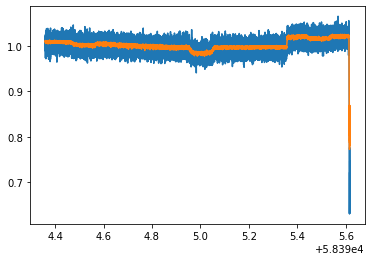

Binned data:
    chi2 = 818.0618766021338
    chi2datum = 0.9797148222780045
    Likelihood = 4167.954798311051
    Evidence = 4104.044196924968
    BIC = -8208.088393849936

Unbinned data:
    chi2 = 40033.909178037065
    chi2datum = 0.751584672737526
    Likelihood = 161192.83230740947
    Evidence = 161089.4432990842
    BIC = -322178.8865981684


In [12]:
# FIX: Save this when running the MCMC, and load if re-making outputs
p0_mcmc, MCMC_Results, residuals = dh.print_MCMC_results(time, flux, time_full, flux_full, chain, lnprobchain, p0_labels,
                                                         p0_astro, mode, channel, p0_obj, signal_inputs, signal_inputs_full,
                                                         signalfunc, astrofunc, usebestfit, savepath, sigF_photon_ppm,
                                                         nFrames, compFactor)

In [13]:
dh.plot_walkers(savepath, mode, p0_astro, p0_fancyLabels, chain, plotCorner=runMCMC)
# FIX - show plot!

In [14]:
# Clear out the RAM
samples = None
sampler = None
chain = None
lnprobchain = None

## Plot the final model (best-fit parameters if usebestfit==True, otherwise median of MCMC chain)

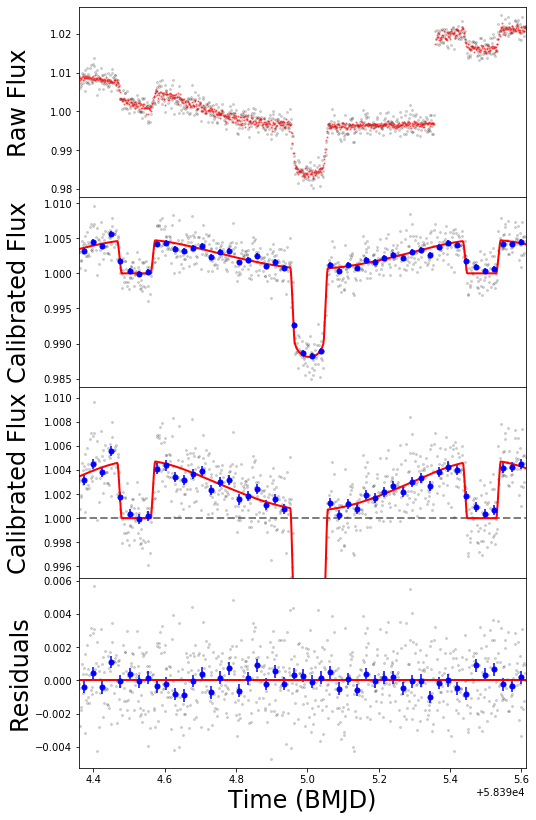

In [15]:
make_plots.plot_bestfit(p0_mcmc, time, flux, mode, p0_obj, p0_astro, p0_labels, signal_inputs, astrofunc, signalfunc, breaks, savepath, nbin=bestfitNbin, showplot=True, fontsize=24)

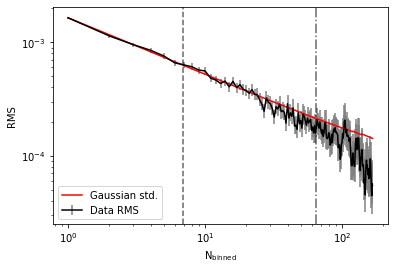

Over Ingress (15.0 min):
Expected Noise (ppm)	Observed Noise (ppm)
673.5973247992687	659.6618335130472
Observed/Expected
0.9793118369489157

Over Transit/Eclipse (139.5 min):
Expected Noise (ppm)	Observed Noise (ppm)
213.89428854381453	157.50844062439032
Observed/Expected
0.7363845088931674


In [16]:
#WARNING: these durations assume circular orbits!!!
intTime = (time[1]-time[0])
ingrDuration = helpers.getIngressDuration(p0_mcmc, p0_labels, p0_obj, intTime)
occDuration = helpers.getOccultationDuration(p0_mcmc, p0_labels, p0_obj, intTime)

minBins = 5

make_plots.plot_rednoise(residuals, minBins, ingrDuration, occDuration, intTime, mode, savepath, savetxt=True)

## Look for residual correlations after fit

In [17]:
if 'pld' not in mode.lower():
    dh.look_for_residual_correlations(time, flux, xdata, ydata, psfxw, psfyw, residuals,
                                      p0_mcmc, p0_labels, p0_obj, mode, savepath)
    #FIX - show the plot